In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [11]:
df = pd.read_excel('mall 2 dataset.xlsx')
df = df[df['CustomerID'].notna()]
df = df.loc[:, ~df.columns.isin(['Manufacturer', 'Manufacturer name','Age'])] ##Additional line of code
df_fix = df.sample(10000, random_state = 42, replace='True')                  ##Small changes done
df_fix.shape
df_fix.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
861,10014761,21814,AccessHer Gold-Plated & Green Embellished Kund...,8,2010-12-01 12:23:00,1.45,17968.0,United Kingdom
1096,10018861,20973,Geox Men Coffee Brown Solid Leather Comfort Sa...,2,2010-12-01 12:54:00,0.65,14078.0,United Kingdom
1045,10024515,22941,HERE&NOW Men Black & Red Colourblocked Reversi...,1,2010-12-01 12:49:00,8.50,15012.0,United Kingdom
121,10006003,37444C,ID Men Grey Solid Thong Flip-Flops,1,2010-12-01 09:41:00,2.95,15311.0,India
466,10017021,85014B,Campus Sutra Men Blue Solid Round Neck T-shirt,3,2010-12-01 11:41:00,5.95,14307.0,United Kingdom


In [12]:
# Convert to show date only
from datetime import datetime
df_fix["InvoiceDate"] = df_fix["InvoiceDate"].dt.date
# Create TotalSum colummn
df_fix["TotalSum"] = df_fix["Quantity"] * df_fix["UnitPrice"]
# Create date variable that records recency
import datetime
snapshot_date = max(df_fix.InvoiceDate) + datetime.timedelta(days=1)
# Aggregate data by each customer
customers = df_fix.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})
# Rename columns
customers.rename(columns = {'InvoiceDate': 'Recency',
                            'InvoiceNo': 'Frequency',
                            'TotalSum': 'MonetaryValue'}, inplace=True)

In [13]:
from scipy import stats
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
customers_fix.tail()

,Recency,Frequency,MonetaryValue
50,233889.362215,2.847627,12.131879
51,233889.362215,5.368756,14.861390
52,233889.362215,10.997021,13.559155
53,233889.362215,6.676272,16.235008
54,233889.362215,6.196950,14.319360


In [14]:
# Import library
from sklearn.preprocessing import StandardScaler
# Initialize the Object
scaler = StandardScaler()
# Fit and Transform The Data
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)
# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(customers_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[ 0. -0. -0.]
[1. 1. 1.]


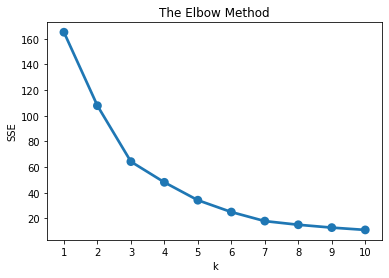

In [15]:
import seaborn as sns
from sklearn.cluster import KMeans

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [16]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(55,)

In [17]:
customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         360.0     26.76       1444.90    17
1         360.0    234.91       5818.05    33
2           3.0    358.60       3160.62     5

C:\Users\Lakshmikanth\Envs\note\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Attribute', ylabel='Value'>

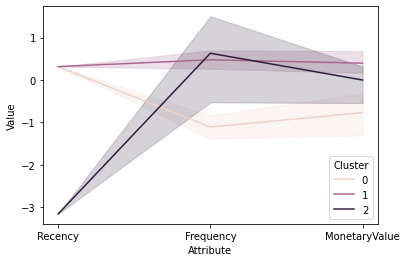

In [18]:
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()
# Visualize it
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)